In [1]:
import nltk

In [3]:
nltk.pos_tag("machine leanring is great".split())

[('machine', 'NN'), ('leanring', 'NN'), ('is', 'VBZ'), ('great', 'JJ')]

In [6]:
# nltk has handful of stemmers, using PorterStemmer
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

print(porter_stemmer.stem('wolves'))

from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize('wolves'))

wolv
wolf


In [ ]:
# Named Entity Recognition (NER)
s = "Albert Eninstein was born on March 14, 1879"
tags = nltk.pos_tag(s.split())
print(tags) #input to names entity recognizer

nltk.download('words')
nltk.download('maxent_ne_chunker')
nltk.ne_chunk(tags)

#nltk.ne_chunk(tags).draw()

#### Latent Semantic Analysis (LSA)

-> is an Unsupervised learning model
-> multiple words with the same meaning (synonymy); ex: buy, purchase
-> one word with multiple meanings (polysemy) ex: Man - human not animal, Man male not female, Milk - Milk or in the context of "Milk it"

Computer, PC, laptop are highly correlated variables, we can represent all these varialbes as one latent varible
i.e transform to Latent varible by reducing number of features.

LSA definitely helps with Synonymy, but there are conflicting views with Polysemy

--> Undelying math behind - SVD
--> Singular Value Decomposition
    Latent Dimensions/Factors
        Ex: similar movie using user rating: millions have watched, hence millions of ratings
        one would finf the distance beween ratings for all the users for any two movies and can say if they are similar..
        since there are millions of users, not ideal => 
        Action-adventure, Super heores/ super powers/main characters are teenagers/ robots -these are varialbes that can describe movies like Power rangers or Transoformer
        So people who like the above 4 categories would like both movies.
        Issue: Can't manually identify latent factors/dimensions
        
        SVD can create Latent factors i.e 
        SVD preserves the strucutre of the data and also reduces dimensionality
 
 LSA is used in Information Retrieval (ex: Google search)

In [1]:
import nltk
import numpy as np
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD

wordnet_lemmatizer = WordNetLemmatizer()

In [2]:
titles = [line.rstrip() for line in open('C:/Users/rpothams/Downloads/BD/NLP/nlp_class/all_book_titles.txt')]
stopwords = set(w.rstrip() for w in open('C:/Users/rpothams/Downloads/BD/NLP/nlp_class/stopwords.txt'))

#adding specific stopwords related to book titles

stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

# addition to stopwords: find top most frequent words and use domain knowledge to remove some words

In [26]:
def my_tokenizer(s):
    s = s.lower()
    tokens = nltk.tokenize.word_tokenize(s)
    tokens = [t for t in tokens if len(t) > 2] #removing short words, probably not useful
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # put words in to base form
    tokens = [t for t in tokens if t not in stopwords]
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
    return tokens

word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []

error_count = 0
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') #if title not ascii ignore #w/o decode, we will get objects
        # .decode() converts to string
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        error_count += 1
        
print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")
    exit()
    
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    try:
        for t in tokens:
            i = word_index_map[t]
            x[i] = 1 # instead of proportion here we just have 1, 0 if the word in the title
    except Exception as e:
        print(e)
    return x

N = len(all_tokens) # number of book titles/document #2373
D = len(word_index_map) # number of terms #2070
X = np.zeros((D, N)) # DxN cause we are doing NLP i.e term-document matrices, not document-term matrices
i = 0

for tokens in all_tokens:
    try:
        X[:,i] = tokens_to_vector(tokens)
    except:
        pass
    i += 1

Number of errors parsing file: 0 number of lines in file: 2373


[[ 0.08161266  0.08804112]
 [ 0.13863466  0.20590939]
 [ 0.02497244  0.0077174 ]
 ...
 [ 0.01059757 -0.0010412 ]
 [ 0.01059757 -0.0010412 ]
 [ 0.01059757 -0.0010412 ]]


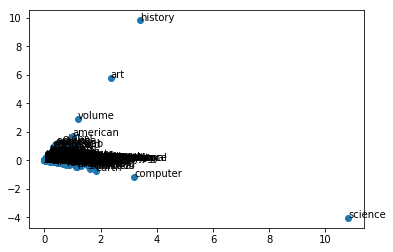

In [30]:
def main():
    svd = TruncatedSVD()
    Z = svd.fit_transform(X)
    print(Z)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(D):
        plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
    plt.show()

if __name__ == '__main__':
    main()

In [ ]:
# As we can see "sciency" stuff and "artsy" stuff seem to be far off from the plot above.
# all book titles i.e D dimensions reduced to d=2 dimensions
# ex: For i = 1 i.e index of term, Z[i,0] and Z[i, 1] are x,y co-rdinates on PC-1 and PC-2 axis

#### Article Spinning

In [31]:
import nltk
import random
import numpy as np
from bs4 import BeautifulSoup

In [41]:
positive_reviews = BeautifulSoup(open('C:/Users/rpothams/Downloads/BD/NLP/nlp_class/electronics/positive.review').read(), 'lxml')
positive_reviews = positive_reviews.findAll('review_text')

# extract trigrams and insert into dictionary
# (w1, w3) is the key, [ w2 ] are the values
trigrams = {}
for review in positive_reviews:
    s = review.text.lower()
    tokens = nltk.tokenize.word_tokenize(s)
    for i in range(len(tokens) - 2):
        try:
            key = (tokens[i], tokens[i+2])
        except Exception as e:
            print(e)
        if key not in trigrams:
            trigrams[key] = []
        trigrams[key].append(tokens[i+1])
        
        
trigrams_probabilities = {}
for key, words in trigrams.items():
    if len(set(words)) > 1:
        d = {}
        n = 0
        for w in words:
            if w not in d:
                d[w] = 0
            d[w] += 1
            n += 1
        for w,c in d.items():
            d[w] = float(c)/n
        trigrams_probabilities[key] = d
        
def random_sample(d):
    '''
    input (d): is dictionary of word and it's probability
    '''
    r = random.random()
    cumulative = 0
    for w, p in d.items():
        cumulative += p
        if r < cumulative:
            return w
        
def test_spinner():
    review = random.choice(positive_reviews)
    s = review.text.lower()
    print("Original: ", s)
    tokens = nltk.tokenize.word_tokenize(s)
    for i in range(len(tokens) - 2):
        if random.random() < 0.2:
            key = (tokens[i], tokens[i+2])
            if key in trigrams_probabilities:
                w = random_sample(trigrams_probabilities[key])
                tokens[i+1] = w
    print( "Spun")
    print(" ".join(tokens).replace(" .", ".").replace(" ,", ",").replace("$ ", "S$").replace(" !", "!"))
    
test_spinner()

Original:  
this map set met all my expectations, and was far more current than i had expected.  software for turn by turn directions on roadways while driving works great with the garmin ctrex gps.  recommended. to load many states you will need large memory card, 1 gb. 

Spun
this speaker set met all my expectations, and was no more current than i had expected. d- for turn by turn it on roadways while driving works great with the garmin ctrex gps. recommended. to load many states you will need large memory card, 1 first.


In [42]:
# Article spinning with Trigrams doesnt produce great results as expected.

#### What we didn't talk about in this class
-> Edit distance
    - insertion, deletion, substitution (to see how close two strings are?) ->did something similar in Genetic Algorithms in ML class
    - dynamic programming is involved

-> Parsing Trees
    - Breaking sentences to tree heirarchy

-> MaxEnt classifiers
    "maximum entropy"